<a href="https://colab.research.google.com/github/anikaSeshan/LandfillNetResearch/blob/main/LandfillNet_Research_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

> Use PyTorch and timm to build and train a CNN model for image classification

In [1]:
!pip install timm
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 44.9 MB/s eta 0:00:00


In [2]:
## import libraries
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import rasterio
from torchvision.transforms import ToTensor


import numpy as np
import os
import pandas as pd
from PIL import Image
import math
import string
import random
import sklearn.metrics
import matplotlib.pyplot as plt

import timm

In [ ]:
print(torch.__version__)

2.1.0+cu121


In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Import The Data
The first step before training the model is to import the data.

If your dataset is already prepared, unzip the file that you have uploaded. Optionally, you can save these files into GDrive and mount the drive for faster access next time.

If the dataset is not already prepared, you will need to download the example dataset from [Kaggle](https://www.kaggle.com/datasets/myprojectdictionary/citrus-leaf-disease-image), upload to this colab notebook, and then process the data with the hidden code section.

Remember to recompute the mean and std of the training data if you are changing your dataset. Place the new mean and std to the transforms.Normalize so you can normalize your incoming input.

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models.
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [ ]:
# @title
# !unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [ ]:
# @title
# reorganize the files
import os
import shutil
import numpy as np
import pandas as pd
import random


def reorganize_files(source_dir, dest_dir):
  train_data = {
      'filename': [],
      'label': [],
  }

  valid_data = {
      'filename': [],
      'label': [],
  }

  test_data = {
      'filename': [],
      'label': [],
  }

  for dirpath, dirnames, filenames in os.walk(source_dir):
    n = len(filenames)
    splits = [0] * int(n * 0.8) + [1] * int(n * 0.1) + [2] * int(n * 0.1)
    while len(splits) < n:
        splits.append(random.choices([0, 1, 2], weights=[0.8, 0.1, 0.1]))
    random.shuffle(splits)

    # skip melanose category
    category = os.path.basename(dirpath)
    # if category == 'Melanose':
      # continue

    for filename, split in zip(filenames, splits):
      src_file = os.path.join(dirpath, filename)
      new_filename = f"{category} {filename}"
      if split == 0:
        dst_file = os.path.join(dest_dir, 'train', new_filename)
        train_data['filename'].append(new_filename)
        train_data['label'].append(category)
      elif split == 1:
        dst_file = os.path.join(dest_dir, 'valid', new_filename)
        valid_data['filename'].append(new_filename)
        valid_data['label'].append(category)
      elif split == 2:
        dst_file = os.path.join(dest_dir, 'test', new_filename)
        test_data['filename'].append(new_filename)
        test_data['label'].append(category)
      shutil.copy(src_file, dst_file)

  train_df = pd.DataFrame(train_data)
  valid_df = pd.DataFrame(valid_data)
  test_df = pd.DataFrame(test_data)

  train_df.to_csv(os.path.join(dest_dir, 'train_labels.csv'))
  valid_df.to_csv(os.path.join(dest_dir, 'valid_labels.csv'))
  test_df.to_csv(os.path.join(dest_dir, 'test_labels.csv'))


reorganize_files('/content/drive/MyDrive/Landfill Images/', '/content/landfill_data/')

In [ ]:
# @title
# !zip -r citrus-leaf-disease-new.zip citrus_data

In [ ]:
!unzip citrus-leaf-disease-new.zip

unzip:  cannot find or open citrus-leaf-disease-new.zip, citrus-leaf-disease-new.zip.zip or citrus-leaf-disease-new.zip.ZIP.


In [ ]:
# Define a generic image dataset class
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        with rasterio.open(img_path) as image_raw:
          image_array = image_raw.read()
        image = Image.fromarray(np.transpose(image_array.astype(np.uint8), (1, 2, 0)))
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# Initialize the data
BATCH_SIZE = 32 #Change as needed

## transformations
train_transform = transforms.Compose([
    transforms.Resize((200, 256)),
    transforms.RandomHorizontalFlip(), #Data Augmentation
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4876, 0.5038, 0.4455], [0.1795, 0.1548, 0.1545]) #[Mean R, Mean G, Mean B, SD R...]
])

test_transform = transforms.Compose([
    transforms.Resize((200, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.4876, 0.5038, 0.4455], [0.1795, 0.1548, 0.1545])
])

label_to_class_map = {
    'Negative': 0,
    'Positive': 1,
}

target_transform = lambda x: label_to_class_map[x]


trainset = ImageDataset('/content/landfill_data/train_labels.csv', '/content/landfill_data/train', transform=train_transform, target_transform=target_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


validset = ImageDataset('/content/landfill_data/valid_labels.csv', '/content/landfill_data/valid', transform=test_transform, target_transform=target_transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


testset = ImageDataset('/content/landfill_data/test_labels.csv', '/content/landfill_data/test', transform=test_transform, target_transform=target_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
# @title
# Compute mean and std of train dataset
def compute_mean_and_std_by_batch(dataloader):
    _, _, image_height, image_width = next(iter(dataloader))[0].shape
    # pixel count
    count = len(dataloader.sampler) * image_height * image_width

    # placeholders
    psum = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for X, _ in dataloader:
        psum += X.sum(axis=[0, 2, 3])

    # compute the mean first
    total_mean = psum / count

    # reshaped the mean for broadcasting
    mean_reshaped = total_mean.reshape((1, 3, 1, 1))

    # placeholders
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for X, _ in dataloader:
        psum_sq += ((X - mean_reshaped) ** 2).sum(axis=[0, 2, 3])

    # mean and std
    total_std = torch.sqrt(psum_sq / count)

    print(f"Mean: {total_mean}")
    print(f"Std: {total_std}")


compute_mean_and_std_by_batch(trainloader)





Mean: tensor([0.4876, 0.5038, 0.4455])
Std: tensor([0.1795, 0.1548, 0.1545])


## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order.

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset.

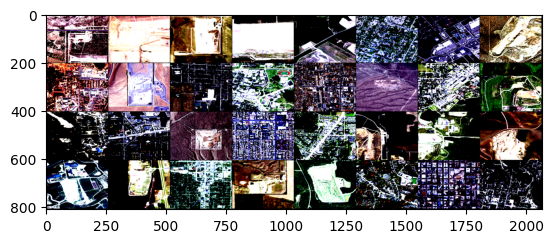

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

**EXERCISE:** Try to understand what the code above is doing. This will help you to better understand your dataset before moving forward.

Let's check the dimensions of a batch.

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([64, 3, 200, 256])
Image label dimensions: torch.Size([64])


## The Model
Now using the classical deep learning framework pipeline, we will use timm to import a SOTA computer vision model. First, we will list out all available models that matches our search term. Next, we run create_model to download the model architecture and weights.

In [ ]:
timm.list_models('*resnet*')

['cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'eca_resnet33ts',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'gcresnet33ts',
 'gcresnet50t',
 'inception_resnet_v2',
 'lambda_resnet26rpt_256',
 'lambda_resnet26t',
 'lambda_resnet50ts',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'nf_resnet26',
 'nf_resnet50',
 'nf_resnet101',
 'nf_seresnet26',
 'nf_seresnet50',
 'nf_seresnet101',
 'resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'r

In [ ]:
chosen_model = 'resnet50'
model = timm.create_model(chosen_model, pretrained=True, num_classes=len(label_to_class_map))

As I have done in my previous tutorials, I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect. If the notebook runs out of memory, reduce the batch size so that the code will not use as much memory and repeat this step.

In [ ]:
## test the model with 1 batch data
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 3, 200, 256])
torch.Size([32, 2])


## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model.

In [ ]:
def get_num_correct(logit, target): #Percision, f1 score, recall, confusion matrix
    y_pred = torch.max(logit, 1)[1].view(target.size())
    corrects = (y_pred.data == target.data).sum()
    return corrects.item()

def freeze_pretrained_layers(model):
    '''Freeze all layers except the last layer(fc or classifier)'''
    for param in model.parameters():
            param.requires_grad = False
    model.fc.weight.requires_grad = True
    model.fc.bias.requires_grad = True

if not os.path.exists('/content/outputs'):
  os.makedirs('/content/outputs')

In [ ]:
## Either download a fresh pretrained model OR load weights from a model that you have previously stored
model = timm.create_model(chosen_model, pretrained=True, num_classes=len(label_to_class_map))
# model = torch.load(f"/content/outputs/model-4T87G.pkl") # Reads weight of the model. Load weights through files

## Optionally freeze pretrained layers to speed up training
# freeze_pretrained_layers(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss() #Loss function: The closer the model is correct to right output, smaller the loss value. Model is training to reduce loss

In [ ]:
learning_rate = 0.0001 #Tuning hyperparameters
num_epochs = 3

optimizer = torch.optim.Adam((param for param in model.parameters() if param.requires_grad), lr=learning_rate) #Different optimizers

Now it's time for training.

In [ ]:
storing_acc_threshold = 50.0
highest_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    train_running_loss = 0.0
    train_correct = 0.0

    model = model.train()

    ## training step
    for images, labels in trainloader:

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item() * images.size(0)
        train_correct += get_num_correct(logits, labels)

    train_running_loss = train_running_loss / len(trainloader.sampler)
    train_acc = train_correct / len(trainloader.sampler) * 100.0

    model.eval()

    ## validation step
    valid_loss = 0.0
    valid_correct = 0

    for images, labels in validloader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        valid_loss += loss.detach().item() * images.size(0)
        valid_correct += get_num_correct(logits, labels)

    valid_loss = valid_loss / len(validloader.sampler)
    valid_acc = valid_correct / len(validloader.sampler) * 100.0

    print(f'Epoch: {epoch} | Train Loss: {train_running_loss:.4f} | Train Accuracy: {train_acc:.2f} | Val Loss: {valid_loss:.4f} | Val Accuracy: {valid_acc:.2f}')

    if valid_acc > storing_acc_threshold and valid_acc > highest_val_acc:
        highest_val_acc = valid_acc
        model_filename = f'model-{"".join(random.choices(string.ascii_uppercase + string.digits, k=5))}.pkl'
        torch.save(model, f'/content/outputs/{model_filename}')
        print(f'Achieved highest val accuracy. Storing model weights in outputs/{model_filename}.')

KeyboardInterrupt: 

# Final Step
Only run this at the very end to report your test accuracy.

We can also compute accuracy on the testing dataset to see how well the model performs on the image classification task.

In [ ]:
test_correct = 0

y_image = []
y_pred = []
y_true = []
y_score = []


for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    y_image.append(images)
    y_score.append(F.softmax(outputs, dim = 1)[:,1])
    test_correct += get_num_correct(outputs, labels)
    y_pred.append(torch.max(outputs, 1)[1].view(labels.size()))
    y_true.append(labels)

y_image = torch.cat(y_image).cpu()
y_true = torch.cat(y_true).cpu()
y_pred = torch.cat(y_pred).cpu()
y_score = torch.cat(y_score).cpu()





In [ ]:
y_image[3]

In [ ]:
test_acc = test_correct / len(testloader.sampler) * 100.0
print(f'Test Accuracy: {test_acc:.2f}')

print(f'Test Precision:  {sklearn.metrics.precision_score(y_true, y_pred)}')

Test Accuracy: 97.10
Test Precision:  0.963302752293578


In [ ]:
print(f'Test Recall: {sklearn.metrics.recall_score(y_true, y_pred)}')
print(f'Test F-1 Score: {sklearn.metrics.f1_score(y_true, y_pred)}')

Test Recall: 0.9813084112149533
Test F-1 Score: 0.9722222222222222


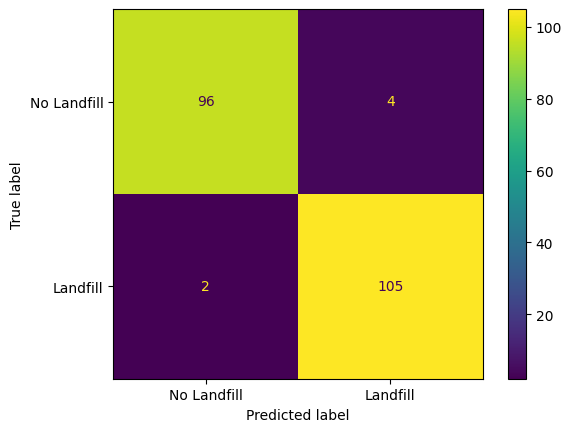

In [ ]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = ["No Landfill", "Landfill"])
disp.plot()


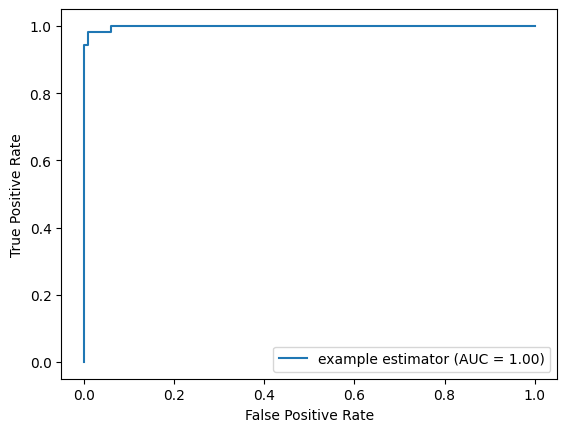

In [ ]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true.detach(), y_score.detach())
roc_auc = sklearn.metrics.auc(fpr, tpr)
display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot() #Change Names

**EXERCISE:** As a way to practise, try to include the testing part inside the code where I was outputing the training accuracy, so that you can also keep testing the model on the testing data as you proceed with the training steps. This is useful as sometimes you don't want to wait until your model has completed training to actually test the model with the testing data.